In [160]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore, pearsonr
from statsmodels.stats.multitest import multipletests

from collections import defaultdict, Counter

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.auto import tqdm
tqdm.pandas()

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/tqdm/_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [190]:
tss1kb_meth = pd.read_hdf("../data/CCLE_RRBS_TSS1kb_20181022.hdf",key="tss1kb_meth")
tssclust_meth = pd.read_hdf("../data/CCLE_RRBS_tss_CpG_clusters_20181022.hdf",key="tssclust_meth")
ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")

avana = pd.read_hdf("../data/Achilles_gene_effect.hdf",key="avana")
drive = pd.read_hdf("../data/D2_DRIVE_gene_dep_scores.hdf",key="drive")
achilles = pd.read_hdf("../data/D2_Achilles_gene_dep_scores.hdf",key="achilles")

avana.columns = ["_".join(x.split("_")[:-1]) for x in avana.columns]
drive.columns = ["_".join(x.split("_")[:-1]) for x in drive.columns]
achilles.columns = ["_".join(x.split("_")[:-1]) for x in achilles.columns]

In [322]:
cell_line_annotations = pd.read_excel("../data/41586_2019_1186_MOESM4_ESM.xlsx",
                                      sheet_name="Cell Line Annotations")


subtypes = cell_line_annotations[["depMapID","type_refined"]].set_index("depMapID")
subtypes = subtypes["type_refined"]
subtypes = subtypes.dropna()
subtypes = subtypes.apply(lambda x: x.capitalize().replace("_"," ")) # preformatting

# rename subtypes to display
rename_map = {"T-cell lymphoma other":"Other T-cell lymphoma",
              "Aml":"AML",
              "Ewings sarcoma": "Ewing's sarcoma",
              "Fibroblast like":"Fibroblast-like",
              "Lung nsc":"Lunc, NSC",
              "Lymphoma hodgkin":"Hodgkin's lymphoma",
              "Lymphoma dlbcl":"DLBCL",
              "T-cell all":"T-cell ALL",
              "B-cell all":"B-cell ALL",
              "Cml":"CML",
              "B-cell lymphoma other":"Other B-cell lymphoma",
              "Leukemia other":"Other leukemia",
              "Lymphoma burkitt":"Burkitt's lymphoma"
             }

subtypes = subtypes.apply(lambda x:rename_map.get(x,x))

# Methylation and mRNA expression

In [192]:
meth_genes = pd.DataFrame(index=tssclust_meth.columns)
meth_genes["gene_name"] = meth_genes.index.map(lambda x: x.split("_")[0])

genex_genes = pd.DataFrame(index=ccle_genex.columns)
genex_genes["gene_name"] = genex_genes.index.map(lambda x: "_".join(x.split("_")[:-1]))
genex_genes["ensembl_id_v"] = genex_genes.index.map(lambda x: x.split("_")[-1])
genex_genes["ensembl_id"] = genex_genes["ensembl_id_v"].apply(lambda x: x.split(".")[0])

In [194]:
genex_gene_map = dict(zip(genex_genes["gene_name"], genex_genes.index))

meth_matched = meth_genes.copy()

meth_matched["genex_id"] = meth_matched["gene_name"].apply(lambda x: genex_gene_map.get(x, ""))

meth_matched = meth_matched[meth_matched["genex_id"]!=""]

def meth_genex_correlate(row):
    meth_name = row.name
    genex_name = row["genex_id"]
    
    meth = tssclust_meth[meth_name].dropna()
    genex = ccle_genex[genex_name].dropna()
    
    meth, genex = meth.align(genex, axis=0, join="inner")
    
    r, pval = pearsonr(meth, genex)
    
    row["corr"] = r
    row["pval"] = pval
    row["n"] = len(meth)
    
    return row

meth_matched = meth_matched.progress_apply(meth_genex_correlate, axis=1)
meth_matched = meth_matched.dropna()

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


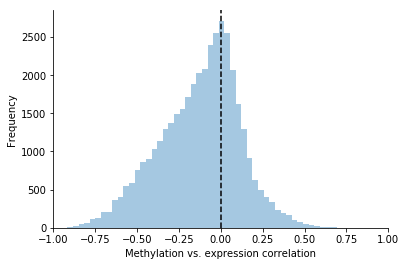

In [195]:
ax = plt.subplot(111)

sns.distplot(meth_matched["corr"],kde=False)
plt.xlabel("Methylation vs. expression correlation")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.ylabel("Frequency")
plt.xlim(-1,1)

plt.axvline(0,linestyle="--",color="black")

In [196]:
high_negative = meth_matched[meth_matched["corr"]<-0.4].copy(deep=True)
high_negative_genes = set(high_negative["gene_name"])

# Methylation and dependency

In [197]:
string = pd.read_csv("../data/9606.protein.links.v11.0.txt.gz",sep=" ")
string = string[string["combined_score"]>=800]

string["protein1_ensembl"] = string["protein1"].apply(lambda x: x[5:])
string["protein2_ensembl"] = string["protein2"].apply(lambda x: x[5:])

ensembl_gene_protein = pd.read_csv("../data/ensembl_gene_protein.txt",sep="\t")
ensembl_gene_protein = ensembl_gene_protein.dropna(subset=["Protein stable ID","NCBI gene ID"])
ensembl_gene_protein["NCBI gene ID"] = ensembl_gene_protein["NCBI gene ID"].astype(int).astype(str)

protein_gene_map = dict(zip(ensembl_gene_protein["Protein stable ID"],ensembl_gene_protein["Gene stable ID"]))

string["gene1_ensembl"]  = string["protein1_ensembl"].apply(lambda x: protein_gene_map.get(x,np.nan))
string["gene2_ensembl"]  = string["protein2_ensembl"].apply(lambda x: protein_gene_map.get(x,np.nan))

string = string.dropna()

In [198]:
ensembl_name_map = dict(zip(genex_genes["ensembl_id"],genex_genes["gene_name"]))
entrez_ensembl_map = dict(zip(ensembl_gene_protein["NCBI gene ID"],ensembl_gene_protein["Gene stable ID"]))

string["gene1_name"] = string["gene1_ensembl"].apply(lambda x: ensembl_name_map.get(x,""))
string["gene2_name"] = string["gene2_ensembl"].apply(lambda x: ensembl_name_map.get(x,""))
string = string[(string["gene1_name"]!="")&(string["gene2_name"]!="")]

In [199]:
# since string contains pairs in both directions, only need to select for one
gene1_valid = string["gene1_name"].isin(high_negative_genes)

string_select = string[gene1_valid].copy(deep=True)

In [200]:
high_negative["locus"] = list(high_negative.index)
genes_meth_map = high_negative.groupby("gene_name")["locus"].apply(list)
genes_meth_map = dict(zip(genes_meth_map.index, genes_meth_map))

In [201]:
string_select["gene1_loci"] = string_select["gene1_name"].apply(lambda x: genes_meth_map[x])
string_select = string_select.explode("gene1_loci")

In [202]:
avana_genes = set(avana.columns)
drive_genes = set(drive.columns)
achilles_genes = set(achilles.columns)

string_select["in_avana"] = string_select["gene2_name"].apply(lambda x: x in avana_genes)
string_select["in_drive"] = string_select["gene2_name"].apply(lambda x: x in drive_genes)
string_select["in_achilles"] = string_select["gene2_name"].apply(lambda x: x in achilles_genes)

string_select_avana = string_select[string_select["in_avana"]]
string_select_drive = string_select[string_select["in_drive"]]
string_select_achilles = string_select[string_select["in_achilles"]]

In [203]:
def meth_dependency_correlate(row, dependency_set):
    meth_name = row["gene1_loci"]
    dependency_name = row["gene2_name"]
    
    meth = tssclust_meth[meth_name].dropna()
    dependency = dependency_set[dependency_name].dropna()
    
    meth, dependency = meth.align(dependency, axis=0, join="inner")
    
    r, pval = pearsonr(meth, dependency)
    
    row["corr"] = r
    row["pval"] = pval
    row["n"] = len(meth)
    
    return row

string_select_avana = string_select_avana.progress_apply(meth_dependency_correlate, 
                                                         dependency_set=avana, axis=1)

string_select_drive = string_select_drive.progress_apply(meth_dependency_correlate, 
                                                         dependency_set=drive, axis=1)

string_select_achilles = string_select_achilles.progress_apply(meth_dependency_correlate, 
                                                         dependency_set=achilles, axis=1)

In [204]:
string_select_avana["qval"] = multipletests(string_select_avana["pval"], alpha=0.01, method="fdr_bh")[1]
string_select_drive["qval"] = multipletests(string_select_drive["pval"], alpha=0.01, method="fdr_bh")[1]
string_select_achilles["qval"] = multipletests(string_select_achilles["pval"], alpha=0.01, method="fdr_bh")[1]



In [234]:
string_select_avana = string_select_avana.reset_index()
string_select_drive = string_select_drive.reset_index()
string_select_achilles = string_select_achilles.reset_index()

In [244]:
string_select_avana["corr_id"] = string_select_avana["gene1_name"]+"-"+string_select_avana["gene2_name"]
string_select_drive["corr_id"] = string_select_drive["gene1_name"]+"-"+string_select_drive["gene2_name"]
string_select_achilles["corr_id"] = string_select_achilles["gene1_name"]+"-"+string_select_achilles["gene2_name"]

string_select_avana = string_select_avana.sort_values(by="pval")
string_select_drive = string_select_drive.sort_values(by="pval")
string_select_achilles = string_select_achilles.sort_values(by="pval")

string_select_avana = string_select_avana.drop_duplicates(subset=["corr_id"],keep="first")
string_select_drive = string_select_drive.drop_duplicates(subset=["corr_id"],keep="first")
string_select_achilles = string_select_achilles.drop_duplicates(subset=["corr_id"],keep="first")

In [248]:
string_select_avana["pval_rank"] = string_select_avana["pval"].rank()
string_select_drive["pval_rank"] = string_select_drive["pval"].rank()
string_select_achilles["pval_rank"] = string_select_achilles["pval"].rank()

In [314]:
def plot_meth_dependency(corr_set, ax):

    ax.scatter(corr_set["corr"],
                -np.log10(corr_set["qval"]),
                c="lightgray"
               )


    select_labels = corr_set[corr_set["pval_rank"]<=10]
    for row_name in list(select_labels.index):
        row = select_labels.loc[row_name]

        ax.text(row["corr"]+0.15,-np.log10(row["qval"])+2,
                 row["gene1_name"]+" ",
                 ha="right",
                 color="#3f72af")
        ax.text(row["corr"]+0.15,-np.log10(row["qval"])+2,
                 "/",
                 ha="center",
                 color="grey")
        ax.text(row["corr"]+0.15,-np.log10(row["qval"])+2,
                 " "+row["gene2_name"],
                 ha="left",
                 color="#e23e57")
        
    ax.set_xlim(-1,1)
    
    ax.set_xticks([-1,-0.5,0,0.5,1])

    ymax = plt.ylim()[1]

    ax.text(1,ymax/30,
                 "Gene X methylation",
                 ha="right",
                 color="#3f72af")
    ax.text(1,ymax/30,
             "  /",
             ha="center",
             color="grey")
    ax.text(1,ymax/30+ymax/30,
             "\nGene Y dependency",
             ha="right",
             va="top",
             color="#e23e57")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel("Pearson correlation")
    ax.set_ylabel("$-log_{10}(q-value)$")

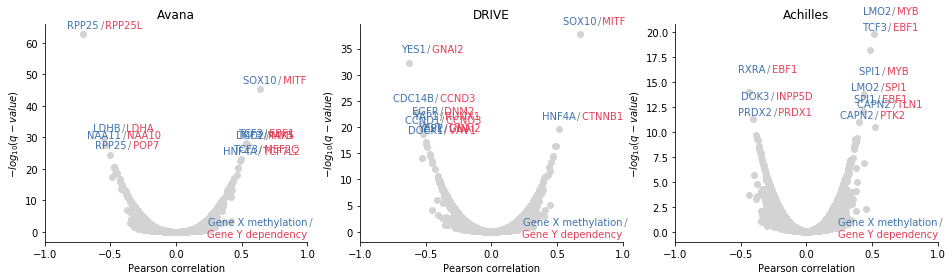

In [317]:
plt.figure(figsize=(16,4))

ax = plt.subplot(131)
plot_meth_dependency(string_select_avana,ax)
plt.title("Avana")

ax = plt.subplot(132)
plot_meth_dependency(string_select_drive,ax)
plt.title("DRIVE")

ax = plt.subplot(133)
plot_meth_dependency(string_select_achilles,ax)
plt.title("Achilles")

plt.show()

# SOX10 methylation

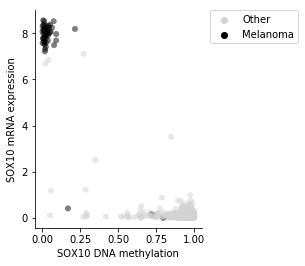

In [406]:
plt.figure(figsize=(3,4))

ax = plt.subplot(111)

meth = tssclust_meth["SOX10_1"].dropna().rename("SOX10_meth")
mrna = ccle_genex["SOX10_ENSG00000100146.12"].rename("SOX10_mrna")

info = pd.concat([meth,mrna,subtypes.rename("subtype")],axis=1,join="inner")
info["melanoma"] = info["subtype"].apply(lambda x: x if x == "Melanoma" else "Other")

sns.scatterplot(info["SOX10_meth"],
                info["SOX10_mrna"],
                hue=info["melanoma"].rename(""),
                palette=sns.color_palette(["lightgrey","black"]),
                linewidth=0,
                alpha=0.5
               )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("SOX10 DNA methylation")
plt.ylabel("SOX10 mRNA expression")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

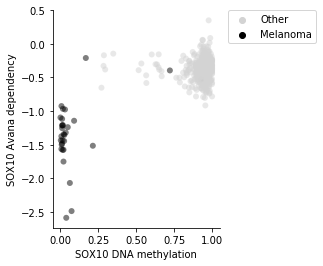

In [405]:
plt.figure(figsize=(3,4))

ax = plt.subplot(111)

meth = tssclust_meth["SOX10_1"].dropna().rename("SOX10_meth")
dependency = avana["SOX10"].rename("SOX10_dependency")

info = pd.concat([meth,dependency,subtypes.rename("subtype")],axis=1,join="inner")
info["melanoma"] = info["subtype"].apply(lambda x: x if x == "Melanoma" else "Other")

sns.scatterplot(info["SOX10_meth"],
                info["SOX10_dependency"],
                hue=info["melanoma"].rename(""),
                palette=sns.color_palette(["lightgrey","black"]),
                linewidth=0,
                alpha=0.5
               )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("SOX10 DNA methylation")
plt.ylabel("SOX10 Avana dependency")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# RPP25 methylation

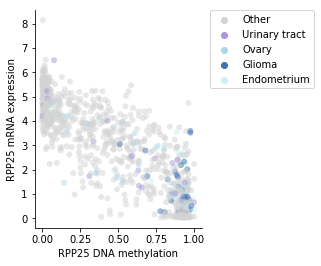

In [407]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(111)

meth = tssclust_meth["RPP25_1"].dropna().rename("RPP25_meth")
mrna = ccle_genex["RPP25_ENSG00000178718.5"].rename("RPP25_mrna")

info = pd.concat([meth, mrna, subtypes.rename(
    "subtype")], axis=1, join="inner")

highlight_subtypes = ["Urinary tract", "Ovary", "Endometrium", "Glioma"]

info["highlight_subtype"] = info["subtype"].apply(
    lambda x: x if x in highlight_subtypes else "Other")

sns.scatterplot(info["RPP25_meth"],
                info["RPP25_mrna"],
                hue=info["highlight_subtype"].rename(""),
                palette={"Other": "lightgrey",
                         "Urinary tract": "#aa96da",
                         "Ovary": "#a8d8ea",
                         "Endometrium": "#cbf1f5",
                         "Glioma": "#3f72af"},
                linewidth=0,
                alpha=0.5
                )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("RPP25 DNA methylation")
plt.ylabel("RPP25 mRNA expression")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

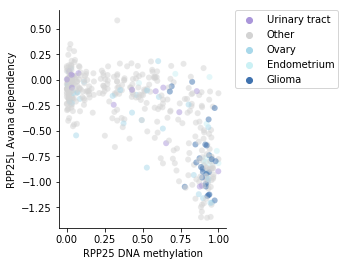

In [404]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(111)

meth = tssclust_meth["RPP25_1"].dropna().rename("RPP25_meth")
dependency = avana["RPP25L"].rename("RPP25L_dependency")

info = pd.concat([meth, dependency, subtypes.rename(
    "subtype")], axis=1, join="inner")

highlight_subtypes = ["Urinary tract", "Ovary", "Endometrium", "Glioma"]

info["highlight_subtype"] = info["subtype"].apply(
    lambda x: x if x in highlight_subtypes else "Other")

sns.scatterplot(info["RPP25_meth"],
                info["RPP25L_dependency"],
                hue=info["highlight_subtype"].rename(""),
                palette={"Other": "lightgrey",
                         "Urinary tract": "#aa96da",
                         "Ovary": "#a8d8ea",
                         "Endometrium": "#cbf1f5",
                         "Glioma": "#3f72af"},
                linewidth=0,
                alpha=0.5
                )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("RPP25 DNA methylation")
plt.ylabel("RPP25L Avana dependency")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# LDHB methylation

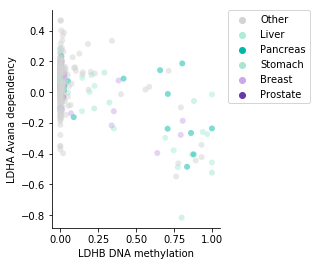

In [403]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(111)

meth = tssclust_meth["LDHB_1"].dropna().rename("LDHB_meth")
dependency = avana["LDHA"].rename("LDHA_dependency")

info = pd.concat([meth, dependency, subtypes.rename(
    "subtype")], axis=1, join="inner")

highlight_subtypes = ["Liver", "Pancreas", "Stomach", "Breast", "Prostate", "Others"]

info["highlight_subtype"] = info["subtype"].apply(
    lambda x: x if x in highlight_subtypes else "Other")

sns.scatterplot(info["LDHB_meth"],
                info["LDHA_dependency"],
                hue=info["highlight_subtype"].rename(""),
                palette={"Other": "lightgrey",
                         "Liver": "#abedd8",
                         "Pancreas": "#00b8a9",
                         "Stomach": "#a8e6cf",
                         "Breast": "#cca8e9",
                         "Prostate": "#6639a6"
                        },
                linewidth=0,
                alpha=0.5
                )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("LDHB DNA methylation")
plt.ylabel("LDHA Avana dependency")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
